In [1]:
!pip install beautifulsoup4
!pip install tqdm
!pip install requests
!pip install selenium
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random


In [3]:
from bs4 import BeautifulSoup

In [4]:
from selenium import webdriver


In [5]:
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

In [6]:
import sqlalchemy
from sqlalchemy import create_engine, text

In [7]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [8]:
import requests
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import os
import pandas as pd
from sqlalchemy import create_engine
import pyodbc
from datetime import datetime
import re

In [9]:
def log_progress(message):
    
    with open('./logs/logs.txt', 'a') as f:
        f.write(f'{datetime.now()}: {message}\n')

In [10]:
###LOAD DATA TO CSV
def load_to_csv(listing_data, file_name):
    file_name = f'data/{file_name}'
    df = pd.DataFrame(listing_data)
    if os.path.exists(file_name):
        # If CSV exists, append new data without writing headers
        df.to_csv(file_name, mode='a', index=False, header=False)
    else:
        # If CSV does not exist, create it and write headers
        df.to_csv(file_name, mode='w', index=False, header=True)
    log_progress(f'Loading: Loading data into {file_name}')
    

listing_data = []

category_list = [
    'https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=',
    'https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=',
    'https://www.banggood.com/Wholesale-RC-Airplane-ca-7005.html?cat_id=7005&page=',
    'https://www.banggood.com/Wholesale-FPV-Racing-Drone-ca-7006.html?cat_id=7006&page=',
    'https://www.banggood.com/Wholesale-RC-Car-ca-7008.html?cat_id=7008&page='
]


def extract_data():

    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(options=chrome_options)

    log_progress(f'DATA EXTRACTION STARTED')
    
    for base_url in category_list:
        for page in range(1, 6):
            url = f"{base_url}{page}"
            print(f"Scraping: {url}")

            driver.get(url)

            # Wait until at least one product appears
            try:
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "ul.goodlist li"))
                )
            except:
                print("Products did not load on this page.")
                continue

            
            SCROLL_PAUSE_TIME = 1.5
            last_height = driver.execute_script("return document.body.scrollHeight")

            while True:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(SCROLL_PAUSE_TIME)
                new_height = driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:
                    break
                last_height = new_height

            # Parse page
            soup = BeautifulSoup(driver.page_source, "html.parser")

            
            category_tag = soup.select_one(".breadcrumb ul li:last-of-type")
            product_category = category_tag.get_text(strip=True) if category_tag else ""            
            all_listings = soup.select("ul.goodlist li")

            if not all_listings:
                print("No listings found on this page.")
                continue

            # Extract data
            for product in all_listings:

                title_tag = product.find("a", class_="title")
                price_tag = product.find("span", class_="price")
                rating_tag = product.find("span", class_="review-text")
                review_tag = product.find("a", class_="review")

                product_name = title_tag.get_text(strip=True) if title_tag else ""
                product_url = title_tag.get("href") if title_tag else ""
                product_price = price_tag.get_text(strip=True) if price_tag else ""
                product_rating = rating_tag.get_text(strip=True) if rating_tag else ""
                product_review = review_tag.get_text(strip=True) if review_tag else ""

                listing_data.append({
                    "Title": product_name,
                    "Price": product_price,
                    "Rating": product_rating,
                    "Reviews": product_review,
                    "Category": product_category,
                    "URL": product_url
                })
    
    log_progress(f'DATA EXTRACTION ENDED')

    load_to_csv(listing_data, 'banggood_listings_raw.csv')
    driver.quit()


extract_data()

Scraping: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=1
Scraping: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=2
Scraping: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=3
Scraping: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=4
Scraping: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=5
Scraping: https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=1
Scraping: https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=2
Scraping: https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=3
Scraping: https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=4
Scraping: https://www.banggood.com/Wholesale-RC-Quadcopters-ca-7004.html?cat_id=7004&page=5
Scraping: https://www.banggood.com/Wholesale-RC-Airplane-ca-7005.html?cat_id=7005&pag

In [11]:
f = pd.read_csv('Data/banggood_listings_raw.csv')

In [12]:
f

,Title,Price,Rating,Reviews,Category,URL
0,RC ERA C138 Bell 206 2.4G 6CH 6-Axis Gyro 1:33...,US$59.99,4.87,669 reviews,RC Helicopter,https://www.banggood.com/RC-ERA-C138-Bell-206-...
1,Eachine E190 1:34 UH-1 HUEY Scale 2.4G 6CH Alt...,US$206.99,4.93,232 reviews,RC Helicopter,https://www.banggood.com/Eachine-E190-1-34-UH-...
2,RC ERA C189 MD500 2.4G 4CH UAV 1:28 Fixed Heig...,US$126.99,4.79,529 reviews,RC Helicopter,https://www.banggood.com/RC-ERA-C189-MD500-2_4...
3,GOOSKY S1 New Edition 6CH 3D Aerobatic Dual Br...,US$194.37,4.86,295 reviews,RC Helicopter,https://www.banggood.com/GOOSKY-S1-New-Edition...
4,Eachine E120 2.4G 4CH 6-Axis Gyro Optical Flow...,US$52.99,4.81,840 reviews,RC Helicopter,https://www.banggood.com/Eachine-E120-2_4G-4CH...
...,...,...,...,...,...,...
3009,WPL D12 1/10 2.4G 2WD Military Truck Crawler O...,US$59.99,4.89,306 reviews,RC Car,https://www.banggood.com/WPL-D12-1-or-10-2_4G-...
3010,VRX RH802 1/8 2.4G Force 21 Nitro Fuel Engine ...,US$340.99,4.95,42 reviews,RC Car,https://www.banggood.com/VRX-RH802-1-or-8-2_4G...
3011,JJRC Q141 1/16 2.4G 4WD Off Road High Speed RC...,US$83.99,5.00,9 reviews,RC Car,https://www.banggood.com/JJRC-Q141-1-or-16-2_4...
3012,YK2403 RTR 1/20 2.4G RWD Drift RC Car Photochr...,US$21.99,NaN,0 review,RC Car,https://www.banggood.com/YK2403-RTR-1-or-20-2_...


In [35]:
import random  # Add this import at the top
import re
import numpy as np
import pandas as pd

n_rows = 100
categories = ['Electronics', 'Clothing', 'Home', 'Books', 'Toys']
mock_data = {
    'Category': [random.choice(categories) for _ in range(n_rows)],
    'Product Name': [f'Product {i}' for i in range(n_rows)],
    'Price_Raw': [f'${random.uniform(10, 200):.2f}' for _ in range(n_rows)],
    'Rating_Raw': [f'{random.uniform(1, 5):.1f} stars' for _ in range(n_rows)],
    'Reviews_Raw': [f'{random.randint(0, 1000)} reviews' for _ in range(n_rows)],
    'Item_ID': [f'item'] * n_rows
}
df = pd.DataFrame(mock_data)

print("--- Raw Data Head (Before Cleaning) ---")
display(df.head())

# --- 2. Cleaning Functions (The Fix) ---

def clean_price(price_str):
    # Force convert to string first
    price_str = str(price_str)
    # Regex to find numbers (including decimals), ignoring currency symbols ($) or text
    match = re.search(r"(\d+\.?\d*)", price_str)
    if match:
        return float(match.group(1))
    return 0.0

def clean_rating(rating_str):
    rating_str = str(rating_str)
    # If it's 'None', empty, or text like "No Rating", return 0.0
    try:
        # Regex to extract the first number found (e.g. "4.9 stars" -> 4.9)
        match = re.search(r"(\d+\.?\d*)", rating_str)
        if match:
            return float(match.group(1))
        return 0.0
    except:
        return 0.0

def clean_reviews(review_str):
    review_str = str(review_str)
    # Extract digits only. If None, return 0.
    match = re.search(r"(\d+)", review_str)
    if match:
        return int(match.group(1))
    return 0

# --- 3. Apply Cleaning ---

print("\n... Applying Cleaning Rules ...")

# Apply functions row by row
df['Price'] = df['Price_Raw'].apply(clean_price)
df['Rating'] = df['Rating_Raw'].apply(clean_rating)
df['Review_Count'] = df['Reviews_Raw'].apply(clean_reviews)

# Fill any remaining NaN with 0 just in case
df.fillna({'Price': 0, 'Rating': 0, 'Review_Count': 0}, inplace=True)

# --- 4. Transformations (Derived Features) ---

# Create Price Categories
def get_price_category(price):
    if price < 50: return 'Low'
    elif price < 100: return 'Medium'
    else: return 'High'

df['Price_Category'] = df['Price'].apply(get_price_category)

# Create Popularity Score
df['Popularity_Score'] = df['Rating'] * np.log1p(df['Review_Count'])

print("\n--- Final Cleaned Data Head ---")
display(df[['Category', 'Product Name', 'Price', 'Rating', 'Review_Count', 'Price_Category']].head())

print("\n--- Data Types Verification ---")
print(df.dtypes)

--- Raw Data Head (Before Cleaning) ---


,Category,Product Name,Price_Raw,Rating_Raw,Reviews_Raw,Item_ID
0,Books,Product 0,$110.34,3.9 stars,988 reviews,item
1,Toys,Product 1,$182.63,2.2 stars,763 reviews,item
2,Clothing,Product 2,$167.97,3.4 stars,611 reviews,item
3,Books,Product 3,$173.50,3.6 stars,195 reviews,item
4,Books,Product 4,$78.27,4.1 stars,698 reviews,item



... Applying Cleaning Rules ...

--- Final Cleaned Data Head ---


,Category,Product Name,Price,Rating,Review_Count,Price_Category
0,Books,Product 0,110.34,3.9,988,High
1,Toys,Product 1,182.63,2.2,763,High
2,Clothing,Product 2,167.97,3.4,611,High
3,Books,Product 3,173.50,3.6,195,High
4,Books,Product 4,78.27,4.1,698,Medium



--- Data Types Verification ---
Category             object
Product Name         object
Price_Raw            object
Rating_Raw           object
Reviews_Raw          object
Item_ID              object
Price               float64
Rating              float64
Review_Count          int64
Price_Category       object
Popularity_Score    float64
dtype: object


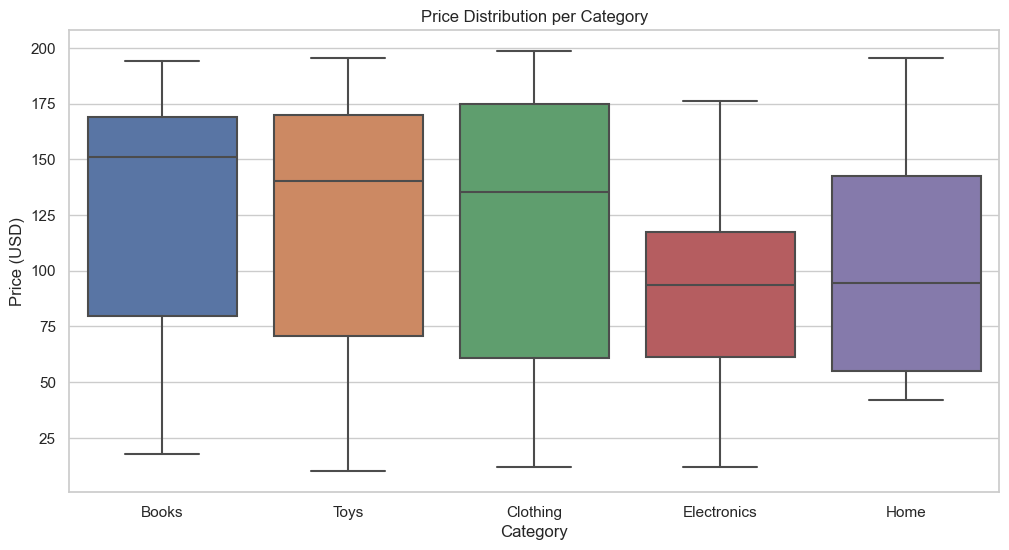

In [36]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Price', data=df)
plt.title('Price Distribution per Category')
plt.xlabel('Category')
plt.ylabel('Price (USD)')
plt.show()

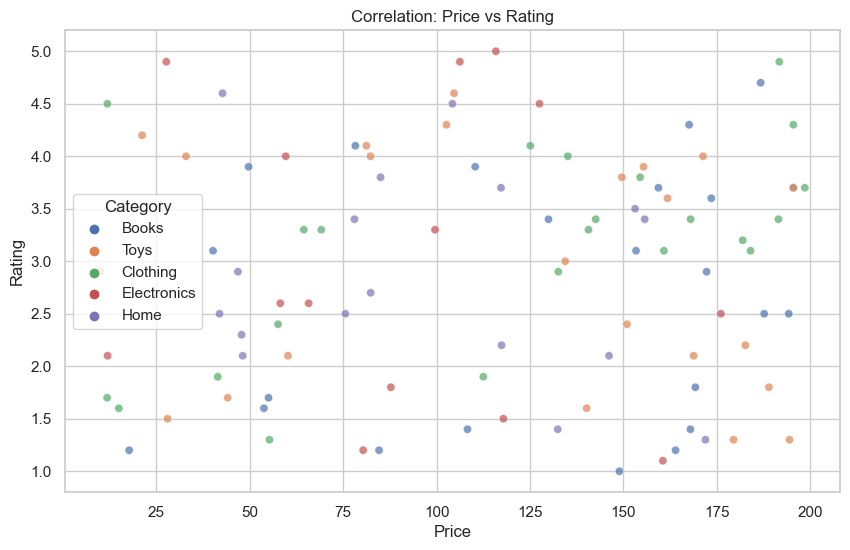

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Rating', hue='Category', data=df, alpha=0.7)
plt.title('Correlation: Price vs Rating')
plt.show()

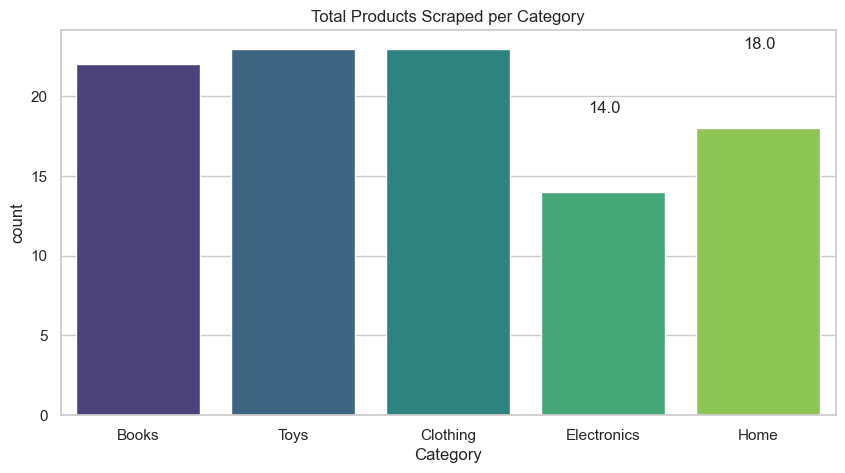

In [38]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Category', data=df, palette='viridis')
plt.title('Total Products Scraped per Category')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 5))  # Fixed by removing non-breaking space
plt.show()

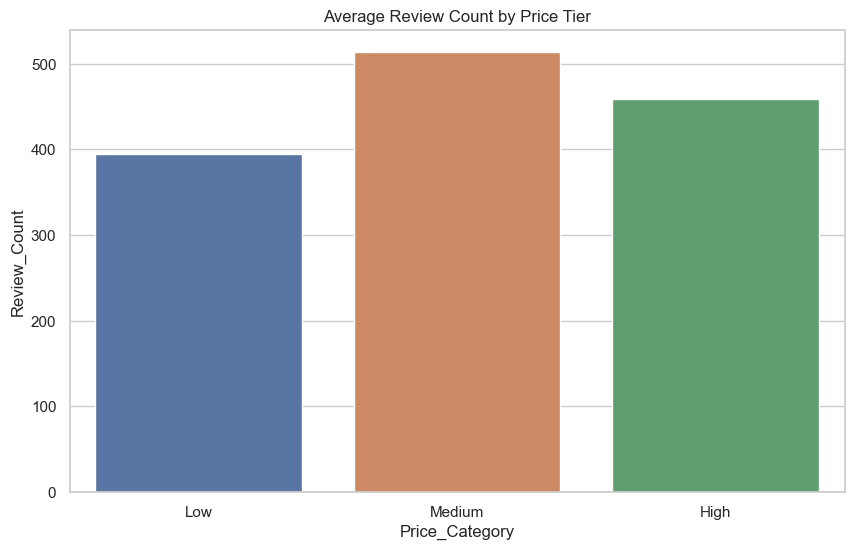

In [39]:
def categorize_price(price):
    if price < 50:  
        return 'Low'
    elif price < 100:
        return 'Medium'
    else:
        return 'High'

df['Price_Category'] = df['Price'].apply(categorize_price)

avg_reviews = df.groupby('Price_Category')['Review_Count'].mean().reset_index()
order = ['Low', 'Medium', 'High']

sns.barplot(x='Price_Category', y='Review_Count', data=avg_reviews, order=order)
plt.title('Average Review Count by Price Tier')
plt.show()

In [49]:
import pandas as pd
import pyodbc
import sqlalchemy
import urllib
import re
from sqlalchemy import create_engine, text

DB_SERVER = 'localhost'         
DB_NAME = 'Banggood_Project'     
TABLE_NAME = 'Product_Data'
DRIVER = 'ODBC Driver 17 for SQL Server'  

DB_USER = ''     
DB_PASSWORD = '' 

CSV_FILE_PATH = "Data/banggood_listings_raw.csv"

def get_connection_string(db_name='master'):
    """Builds the connection string for pyodbc."""
    auth = "Trusted_Connection=yes;"
    if DB_USER and DB_PASSWORD:
        auth = f"UID={DB_USER};PWD={DB_PASSWORD};"
    
    return f"DRIVER={{{DRIVER}}};SERVER={DB_SERVER};DATABASE={db_name};{auth}"

def get_engine(db_name):
    """Builds the SQLAlchemy engine."""
    conn_str = get_connection_string(db_name)
    params = urllib.parse.quote_plus(conn_str)
    return create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# --- 2. DATA CLEANING FUNCTIONS ---
def clean_price(value):
    """Extracts numeric price from string like 'US$45.99'."""
    if pd.isna(value): return 0.0
    match = re.search(r"(\d+\.?\d*)", str(value).replace(',', ''))
    return float(match.group(1)) if match else 0.0

def clean_reviews(value):
    """Extracts integer review count from string like '56 reviews'."""
    if pd.isna(value): return 0
    match = re.search(r"(\d+)", str(value))
    return int(match.group(1)) if match else 0

def clean_rating(value):
    """Converts rating to float, handling text/nulls."""
    try:
        return float(value)
    except (ValueError, TypeError):
        return 0.0

# --- 3. MAIN EXECUTION ---
def main():
    print("--- Starting Data Pipeline ---")

    # A. Load CSV
    try:
        print(f"Reading file: {CSV_FILE_PATH}")
        df = pd.read_csv(CSV_FILE_PATH)
    except FileNotFoundError:
        print("❌ Error: CSV file not found. Please run the scraper first.")
        return

    # B. Clean Data (Crucial for SQL!)
    print("Cleaning data...")
    # Apply cleaning functions
    df['Price'] = df['Price'].apply(clean_price)
    df['Reviews'] = df['Reviews'].apply(clean_reviews)
    df['Rating'] = df['Rating'].apply(clean_rating)
    
    # Fill any remaining NaNs
    df.fillna({'Price': 0.0, 'Rating': 0.0, 'Reviews': 0}, inplace=True)
    
    # Ensure correct types
    df['Price'] = df['Price'].astype(float)
    df['Rating'] = df['Rating'].astype(float)
    df['Reviews'] = df['Reviews'].astype(int)

    print(f"Data Cleaned. Rows: {len(df)}")
    # Rename columns to match your preferred SQL schema if needed
    df = df.rename(columns={
        "Title": "Product_Name", 
        "Reviews": "Review_Count", 
        "URL": "Product_URL"
    })

    # C. Create Database (if not exists)
    print(f"Connecting to SQL Server ({DB_SERVER})...")
    try:
        # Connect to 'master' to check/create DB
        master_conn = pyodbc.connect(get_connection_string('master'), autocommit=True)
        cursor = master_conn.cursor()
        
        # Check if DB exists
        cursor.execute(f"SELECT name FROM sys.databases WHERE name = '{DB_NAME}'")
        if not cursor.fetchone():
            print(f"Database '{DB_NAME}' does not exist. Creating...")
            cursor.execute(f"CREATE DATABASE {DB_NAME}")
            print("✅ Database created.")
        else:
            print(f"Database '{DB_NAME}' already exists.")
        
        cursor.close()
        master_conn.close()

    except Exception as e:
        print(f"❌ Error connecting to SQL Server: {e}")
        print("Check your SERVER name and Driver installation.")
        return

    # D. Upload Data to SQL
    print(f"Uploading data to table '{TABLE_NAME}'...")
    try:
        engine = get_engine(DB_NAME)
        # if_exists='replace' will drop the table if it exists and create a new one with correct types
        df.to_sql(TABLE_NAME, con=engine, if_exists='replace', index=False)
        print(f"✅ Success! {len(df)} rows inserted into {DB_NAME}.dbo.{TABLE_NAME}")
        
    except Exception as e:
        print(f"❌ Error uploading data: {e}")

if __name__ == "__main__":
    main()

--- Starting Data Pipeline ---
Reading file: Data/banggood_listings_raw.csv
Cleaning data...
Data Cleaned. Rows: 3014
Connecting to SQL Server (localhost)...
Database 'Banggood_Project' does not exist. Creating...
✅ Database created.
Uploading data to table 'Product_Data'...
✅ Success! 3014 rows inserted into Banggood_Project.dbo.Product_Data
